# NLP with disaster tweets - A case for LSTM
In this notebook we try to predict which Tweets are about real disasters and which ones are not. We use the data from [https://www.kaggle.com/competitions/nlp-getting-started](https://www.kaggle.com/competitions/nlp-getting-started) and implement a simple solution based on LSTM

In [75]:
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from sklearn.metrics import classification_report

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

import string

# For pre-processing, we use the simple nltk library. You might want to upgrade to SpaCy for better results
import nltk
nltk.download('stopwords')
nltk.download('punkt')

from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
import seaborn as sns

from collections import defaultdict

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hammd\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hammd\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


# 1. Load Data
Load data and reduce to the features we are interested in. Keep in mind that the target is a binary variable with 0 (no disaster) and 1 (disaster)


In [76]:
df = pd.read_csv("data/train.csv")
df = df[["text", "target"]]
print(df.shape)
df

(7613, 2)


,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,@aria_ahrary @TheTawniest The out of control w...,1
7610,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,Police investigating after an e-bike collided ...,1


# 1. Cleaning & Pre-Processing

Remove punctuation

In [77]:
def remove_punctuation(text):
    tokenizer = nltk.RegexpTokenizer(r'\w+')  # remove punctuation and other non-word characters
    tokens = tokenizer.tokenize(text)
    return ' '.join(tokens)

df['text'] = df['text'].apply(remove_punctuation)
df

,text,target
0,Our Deeds are the Reason of this earthquake Ma...,1
1,Forest fire near La Ronge Sask Canada,1
2,All residents asked to shelter in place are be...,1
3,13 000 people receive wildfires evacuation ord...,1
4,Just got sent this photo from Ruby Alaska as s...,1
...,...,...
7608,Two giant cranes holding a bridge collapse int...,1
7609,aria_ahrary TheTawniest The out of control wil...,1
7610,M1 94 01 04 UTC 5km S of Volcano Hawaii http t...,1
7611,Police investigating after an e bike collided ...,1


Remove stopwords

In [78]:
def remove_stopwords(text):
    # Tokenize the text
    words = nltk.word_tokenize(text)

    # Remove stopwords
    words = [word for word in words if word.lower() not in stopwords.words('english')]

    return ' '.join(words)

df['text'] = df['text'].apply(remove_stopwords)
df

,text,target
0,Deeds Reason earthquake May ALLAH Forgive us,1
1,Forest fire near La Ronge Sask Canada,1
2,residents asked shelter place notified officer...,1
3,13 000 people receive wildfires evacuation ord...,1
4,got sent photo Ruby Alaska smoke wildfires pou...,1
...,...,...
7608,Two giant cranes holding bridge collapse nearb...,1
7609,aria_ahrary TheTawniest control wild fires Cal...,1
7610,M1 94 01 04 UTC 5km Volcano Hawaii http co zDt...,1
7611,Police investigating e bike collided car Littl...,1


# Build a dictionary of words
Our LSTM will read a sequence of words. Keep in mind that an LSTM can not handle words but, only numbers. We therefore need a good way to encode our words as numbers. To do so we need to know upfront all words in our corpus. This is what we build up here

In [79]:
all_words_dictionary = defaultdict(int)  # each new key in the dictionary gets default value 0

# we go through all tweets & words to build up the dictionary.
# While doing so, we also count the word occurrences (we don't use the information right now - could be a potential improvement)

for row in df['text']:
    # Tokenize the text into words
    words = row.split()

    # update the word frequency in the dictionary
    for word in words:
        all_words_dictionary[word] += 1

# convert the dictionary to a regular dictionary (so if you try to access a non-existing key, now, you'll get an error)
all_words_dictionary = dict(all_words_dictionary)

word_to_id = {}
id_counter = 1  # we start from 1, 0 is reserved for unknown words
for word in all_words_dictionary.keys():
    word_to_id[word] = id_counter
    id_counter += 1

f"Number of different words in all tweets: {len(all_words_dictionary)}"

'Number of different words in all tweets: 25490'

# Max Sequence Length
As tweets have different lengths, we also need to know what's the maximum length of a sequence. We then "pad" all other sequence to that length.
A performance improvement would be to do so for each batch instead of the whole dataset.

In [80]:
max_seq_len = -1

for text in df['text']:
    words = text.split()  # split the text into words
    seq_len = len(words)  # calculate the sequence length (number of words)
    if seq_len > max_seq_len:
        print(text)
        max_seq_len = seq_len

f"Maximum sequence lenght: {max_seq_len}"

Deeds Reason earthquake May ALLAH Forgive us
residents asked shelter place notified officers evacuation shelter place orders expected
RockyFire Update California Hwy 20 closed directions due Lake County fire CAfire wildfires
Haha South Tampa getting flooded hah WAIT SECOND LIVE SOUTH TAMPA GON NA GON NA FVCK flooding
Barbados Bridgetown JAMAICA ÛÒ Two cars set ablaze SANTA CRUZ ÛÓ Head St Elizabeth Police Superintende http co wDUEaj8Q4J
Accident left lane blocked Manchester Rt 293 NB Eddy Rd stop go traffic back NH 3A delay 4 mins traffic
9 Mile backup 77 South accident blocking Right 2 Lanes Exit 31 Langtree Rd consider NC 115 NC 150 NC 16 alternate
Chevrolet Avalanche LT 2011 lt used 5 3 l v 8 16 v automatic 4 wd pickup truck premium b Û_ http co OBkY8Pc89H http co dXIRnTdSrd


'Maximum sequence lenght: 27'

# Split data stratified
While Kaggle provides a train and test set, we only know the target label for the training set. We therefore split the training data in a stratified way.

In [81]:
# Split data into training and testing

X = df['text']
y = df['target']

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(len(X_train))

# Check the class distribution in the training and validation sets
print("Training set class distribution:")
print(y_train.value_counts(normalize=True))

print("\nValidation set class distribution:")
print(y_valid.value_counts(normalize=True))

5709
Training set class distribution:
target
0    0.570328
1    0.429672
Name: proportion, dtype: float64

Validation set class distribution:
target
0    0.570378
1    0.429622
Name: proportion, dtype: float64


# Hyperparameter Configuration
There are several important hyperparameters we can configure. For simplicity, we define them here altogether

In [82]:
BATCH_SIZE = 32  # specifies the number of samples that will be passed through the network at one time
LEARNING_RATE = 1e-3
DROPOUT = 0.5  # prevent overfitting
INPUT_SIZE = len(all_words_dictionary) + 1  # dimension of input layer of the model --> each word is a unique input + one for unknown words
HIDDEN_DIM = 128  # number of features in the hidden state.
LSTM_LAYERS = 2  # number of LSTM layers stacked together
EPOCHS = 10
OUTPUT_SIZE = 2  # number of output classes

# 2. Dataset & Data Loader
By using the Dataset/Dataloader classes, we allow pytorch to efficiently load, batch and cache data. While there are many predefined datasets (e.g., to load images from folders), we define here our own.

In [83]:
class TweetDataset(Dataset):
    def __init__(self, x, y, max_length, dictionary):
        self.x = self.tokenizer(x, max_length, dictionary)
        self.y = y.to_numpy()

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

    @staticmethod
    def tokenizer(x_all, max_length, dictionary):
        """
        Given a sequence of words, tokenize by space, use the prepared dictionary
        to encode the word and pad the sequence to max_sequence_length
        """
        sequences = []
        for sentence in x_all:
            # tokenize the sentence into words
            _words = sentence.split()

            # encode words using the prepared dictionary
            encoded_sentence = [dictionary.get(_word, 0) for _word in _words]  # use 0 for unknown words

            # pad the sequence to max_length if it's shorter
            if len(encoded_sentence) < max_length:
                pad_length = max_length - len(encoded_sentence)
                encoded_sentence += [0] * pad_length  # pad with zeros

            sequences.append(encoded_sentence)

        return sequences


In [84]:
# build datasets for test and validation
train = TweetDataset(X_train, y_train, max_seq_len, all_words_dictionary)
validation = TweetDataset(X_valid, y_valid, max_seq_len, all_words_dictionary)

# initialize dataloader for test and train
loader_training = DataLoader(train, batch_size=BATCH_SIZE, shuffle=False)
loader_validation = DataLoader(validation, batch_size=BATCH_SIZE, shuffle=False)

# 3. Model
Now the fun part starts: we define the model. While the core of the model is an LSTM, we also need embeddings to encode the input and linear layers for the final classification

In [85]:
class TweetTextClassifier(nn.Module):
    """
    LSTM Network definition
    """
    def __init__(self):
        super(TweetTextClassifier, self).__init__()
        self.embedding = nn.Embedding(INPUT_SIZE, HIDDEN_DIM)
        self.lstm = nn.LSTM(HIDDEN_DIM, HIDDEN_DIM, LSTM_LAYERS, dropout=DROPOUT, batch_first=True)
        self.dropout = nn.Dropout(DROPOUT)
        self.fc = nn.Linear(HIDDEN_DIM, 1)


    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, (ht, ct) = self.lstm(embedded)
        out = self.dropout(ht[-1])
        out = self.fc(out)
        return out

In [86]:
# define the device on which we load the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [87]:
# Model initialization
model = TweetTextClassifier().to(device)

# Optimizer initialization.
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

model

TweetTextClassifier(
  (embedding): Embedding(25491, 128)
  (lstm): LSTM(128, 128, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)

In [88]:
def calculate_accuracy(y_true, y_pred_probs, threshold=0.5):
    """
    Calculates the accuracy of predictions against the true labels.

    Args:
    - y_true (list or numpy array): The actual labels.
    - y_pred_probs (list or numpy array): The predicted probabilities.
    - threshold (float): The threshold for converting probabilities to binary predictions.

    Returns:
    - accuracy (float): The percentage of correct predictions.
    """
    # Convert probabilities to binary predictions based on the threshold
    y_pred = [1 if prob > threshold else 0 for prob in y_pred_probs]

    # Ensure y_true is a numpy array to facilitate element-wise comparison
    y_true = np.array(y_true)

    # Calculate the number of correct predictions
    correct_predictions = np.sum(y_true == y_pred)

    # Calculate the accuracy
    accuracy = correct_predictions / len(y_true)

    return accuracy

In [89]:
# Training
train_loss_list = []
train_acc_list = []
test_acc_list = []

for epoch in range(EPOCHS):

    # Training
    model.train()
    train_predictions = []
    for x_batch, y_batch in loader_training:
        x = torch.stack(x_batch).transpose(0, 1).to(device)
        y = y_batch.to(device)

        y_pred = model(x)

        loss = F.binary_cross_entropy_with_logits(y_pred, y.unsqueeze(1).float(), reduction='mean')

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Flatten y_pred and convert it to a list of 0s and 1s based on the threshold
        y_pred_list = [1 if pred > 0.5 else 0 for pred in y_pred.squeeze().detach().cpu().numpy()]

        # Save predictions for metrics calculation
        train_predictions += y_pred_list

    train_accuracy = calculate_accuracy(y_train, train_predictions)
    train_acc_list.append(train_accuracy)

    # Evaluation
    with torch.no_grad():
        model.eval()
        validation_predictions = torch.Tensor().to(device)

        for x_batch, y_batch in loader_validation:
            x = torch.stack(x_batch).transpose(0, 1).to(device)
            y = y_batch.to(device)

            y_pred = model(x)

            # Aggregate predictions
            validation_predictions = torch.cat((validation_predictions, y_pred), 0)

    binary_predictions = (validation_predictions.sigmoid() > 0.5).long().cpu().numpy()
    test_accuracy = calculate_accuracy(y_valid, binary_predictions)
    test_acc_list.append(test_accuracy)

    train_loss_list.append(loss.item())

    print(f"epoch: {epoch}, loss: {loss.item():.5f}, train: {train_accuracy:.5f}, test: {test_accuracy:.5f}")

    if epoch == 0 or epoch == EPOCHS-1 or epoch == math.floor(EPOCHS/2):
        print(classification_report(y_valid, [1 if x > 0.5 else 0 for x in binary_predictions], zero_division=0))

epoch: 0, loss: 0.64533, train: 0.58995, test: 0.66544
              precision    recall  f1-score   support

           0       0.68      0.77      0.72      1086
           1       0.63      0.52      0.57       818

    accuracy                           0.67      1904
   macro avg       0.66      0.65      0.65      1904
weighted avg       0.66      0.67      0.66      1904

epoch: 1, loss: 0.70564, train: 0.66229, test: 0.68645
epoch: 2, loss: 0.72928, train: 0.69644, test: 0.70326
epoch: 3, loss: 0.64778, train: 0.72377, test: 0.69538
epoch: 4, loss: 0.68923, train: 0.74181, test: 0.67437
epoch: 5, loss: 0.54665, train: 0.77404, test: 0.67384
              precision    recall  f1-score   support

           0       0.75      0.64      0.69      1086
           1       0.60      0.72      0.66       818

    accuracy                           0.67      1904
   macro avg       0.68      0.68      0.67      1904
weighted avg       0.69      0.67      0.68      1904

epoch: 6, loss: 

## Print metrics

<Axes: >

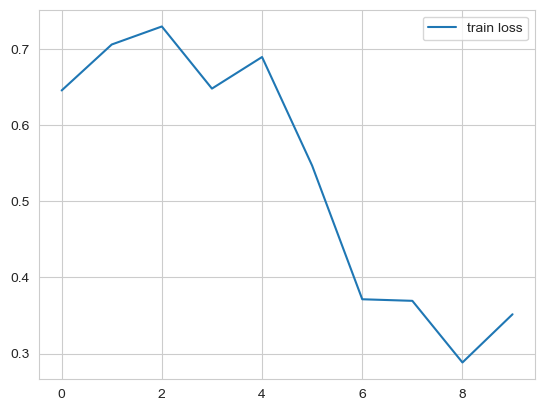

In [90]:
sns.lineplot(x=list(range(EPOCHS)),y=train_loss_list, label='train loss')

<Axes: >

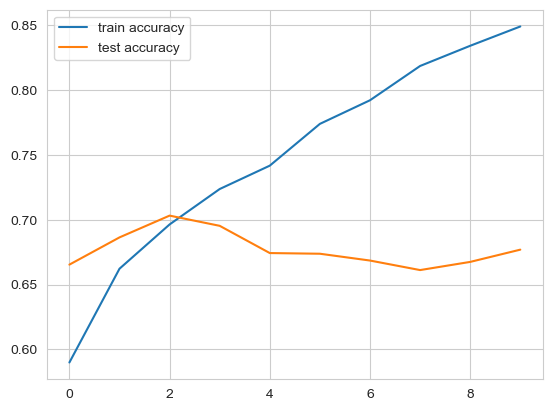

In [91]:
sns.lineplot(x=list(range(EPOCHS)),y=train_acc_list, label="train accuracy")
sns.lineplot(x=list(range(EPOCHS)),y=test_acc_list, label="test accuracy")